In [2]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
kacper=r"d:\Foldery Użytkownika\Pobrane\activities.csv"
igor=r"c:\Users\igors\Desktop\activities.csv"

Text(0.5, 1.0, 'liczba aktywności')

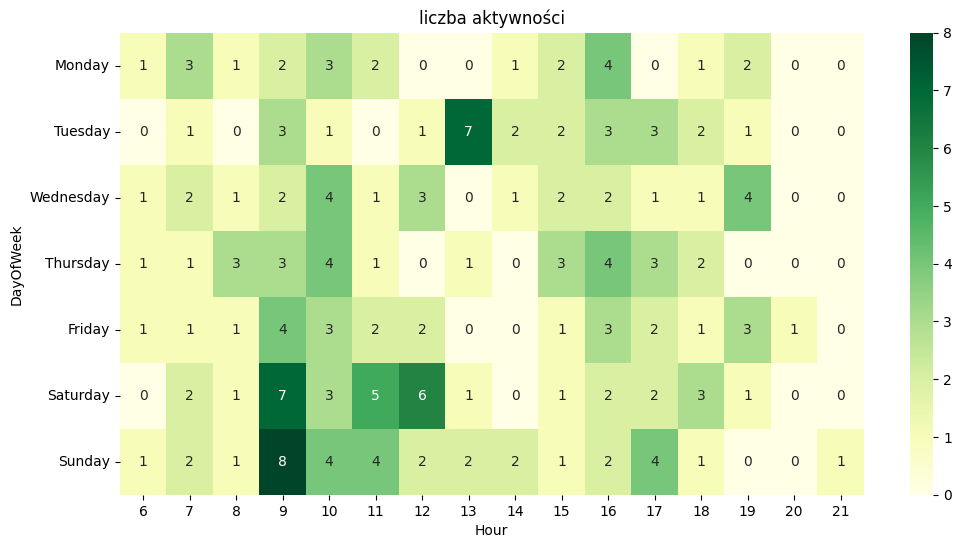

In [3]:
df=pd.read_csv(igor)
days_of_week={0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}
df["Activity Date"]=pd.to_datetime(df["Activity Date"]).dt.tz_localize('UTC').dt.tz_convert('Europe/Warsaw')
df=df.dropna(axis=1,how="all")
df_clean=(df[["Activity ID","Activity Date","Activity Type","Elapsed Time","Max Heart Rate","Average Heart Rate","Commute"]]
            .query("`Activity Type` not in ['Walk','Workout','Weight Training'] and Commute == False"))
df_weeks=df_clean.copy()
df_weeks["DayOfWeek"]=df_weeks["Activity Date"].dt.day_of_week
df_weeks["Hour"]=df_weeks["Activity Date"].dt.hour
df_weeks["Minute"]=df_weeks["Hour"]*60+df_weeks["Activity Date"].dt.minute
df_weeks_minutes=df_weeks.copy()
df_weeks_minutes["Elapsed Time"]=round(df_weeks_minutes["Elapsed Time"]/60).astype("int64")
weeks_and_hours_no=df_weeks.pivot_table(values="Activity ID", aggfunc="nunique",index="DayOfWeek",columns="Hour",fill_value=0).rename(index=days_of_week)
weeks_and_hours_time=df_weeks_minutes.pivot_table(values="Elapsed Time", aggfunc="sum",index="DayOfWeek",columns="Hour",fill_value=0).rename(index=days_of_week)

plt.figure(figsize=(12,6))
sns.heatmap(weeks_and_hours_no,annot=True,cmap="YlGn",fmt=".0f")
plt.title("liczba aktywności")

Text(0.5, 1.0, 'łączna długość aktywności w minutach')

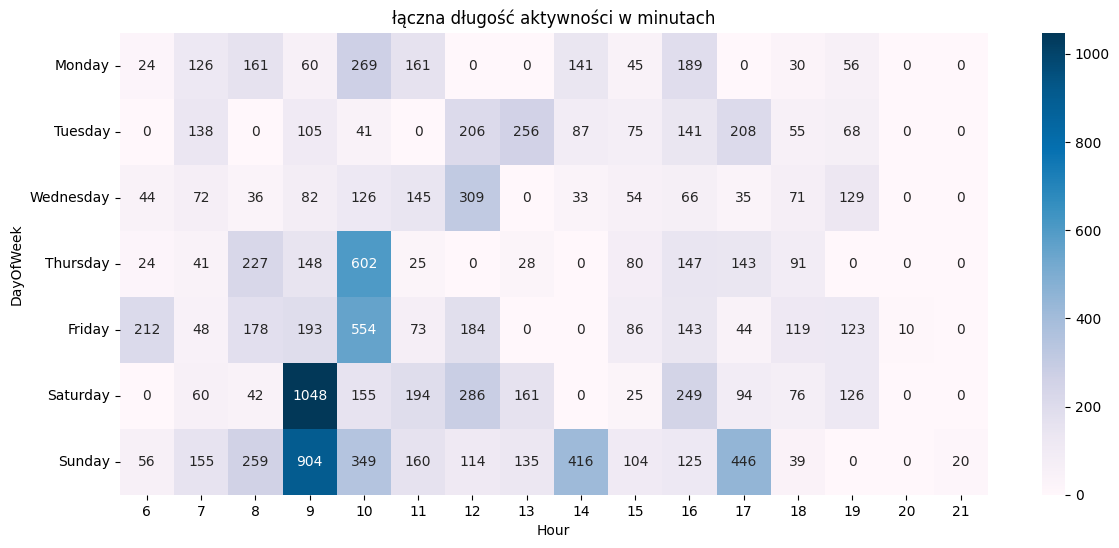

In [4]:
plt.figure(figsize=(14,6))
sns.heatmap(weeks_and_hours_time,annot=True,cmap="PuBu",fmt=".0f")
plt.title("łączna długość aktywności w minutach")

In [5]:
minutes_in_day=np.arange(60*24)
minutes_named = pd.date_range("00:00", "23:59", freq="1min").strftime('%H:%M')
display(df_weeks)
activity_starts=df_weeks["Minute"].values[:,None]
activity_ends=activity_starts+(df_weeks["Elapsed Time"]/60).values[:,None]
activity_mask=(minutes_in_day>=activity_starts) & (minutes_in_day<=activity_ends).astype(int)
activity_heatmap=(pd.DataFrame(activity_mask,index=df_weeks["Activity ID"],columns=minutes_named)
                    .reset_index()
                    .merge(df_weeks[["Activity ID","DayOfWeek"]],left_on="Activity ID",right_on="Activity ID")
                    .drop(columns="Activity ID")
                    .groupby("DayOfWeek").sum()
                    .rename(index=days_of_week)
                    .fillna(0))

,Activity ID,Activity Date,Activity Type,Elapsed Time,Max Heart Rate,Average Heart Rate,Commute,DayOfWeek,Hour,Minute
0,10766111396,2024-02-15 10:12:55+01:00,Ride,4080,NaN,NaN,False,3,10,612
1,10890134141,2024-02-15 16:24:46+01:00,Ride,2317,NaN,NaN,False,3,16,984
3,10890134195,2024-02-24 17:13:41+01:00,Ride,3055,NaN,NaN,False,5,17,1033
5,10890134233,2024-02-25 11:42:03+01:00,Ride,4743,NaN,NaN,False,6,11,702
7,10890134252,2024-02-26 16:53:42+01:00,Ride,2216,177.0,155.0,False,0,16,1013
...,...,...,...,...,...,...,...,...,...,...
425,17281063413,2026-02-04 09:22:29+01:00,Rowing,1956,169.0,140.0,False,2,9,562
426,17304638380,2026-02-06 09:41:07+01:00,Rowing,2118,161.0,146.0,False,4,9,581
427,17313834477,2026-02-07 09:28:59+01:00,Rowing,2151,171.0,150.0,False,5,9,568
428,17336791441,2026-02-09 09:38:40+01:00,Rowing,1650,178.0,144.0,False,0,9,578


Pretty

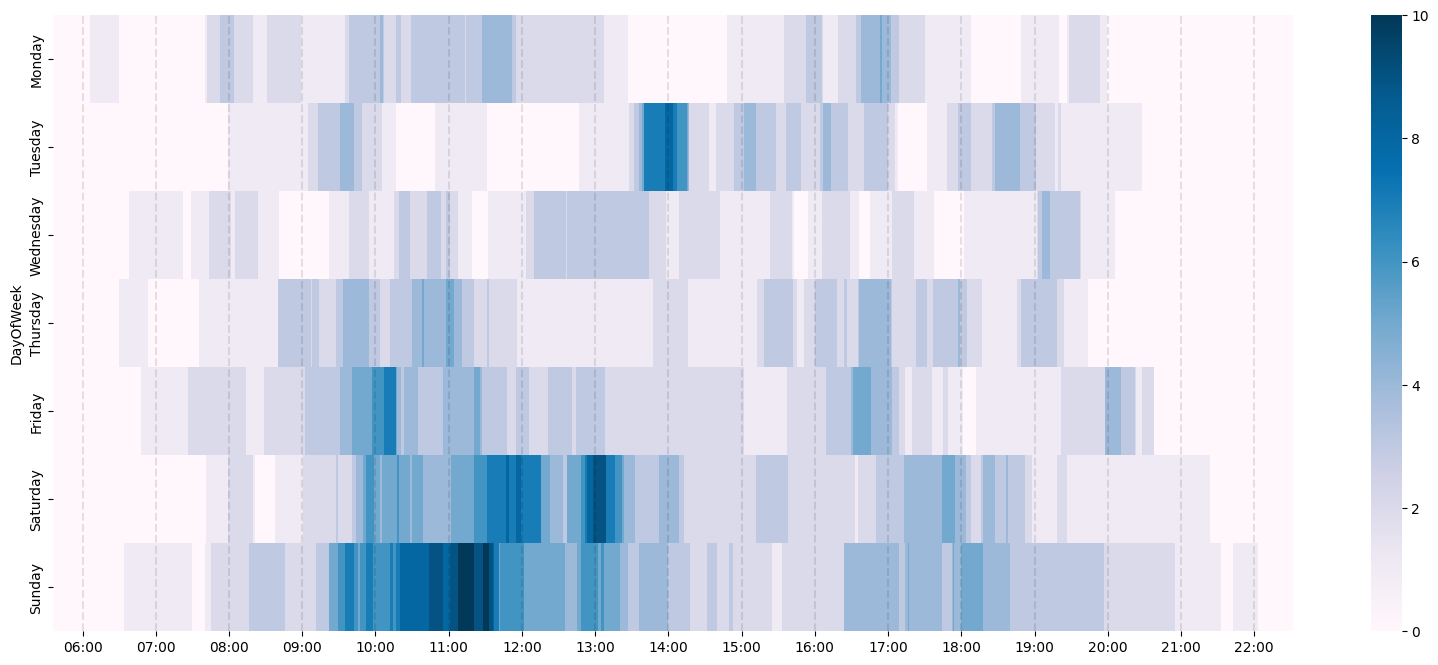

In [6]:
activity_sum=activity_heatmap.sum()
active_minutes=activity_sum.to_numpy().nonzero()[0]
margin=30
if len(active_minutes)>0:
    first_idx=active_minutes[0]
    last_idx=active_minutes[-1]
    start_cut = max(0, first_idx - margin)
    end_cut = min(1440, last_idx + margin)
    heatmap_cropped=activity_heatmap.iloc[:,start_cut:end_cut]
plt.figure(figsize=(20, 8))
ax=sns.heatmap(heatmap_cropped,cmap="PuBu",xticklabels=False)
cols=heatmap_cropped.columns
ticks=[i for i, name in enumerate(cols) if name.endswith(":00")]
labels=[cols[i] for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.vlines(ticks, *ax.get_ylim(), colors="black", linestyles="--", alpha=0.1)

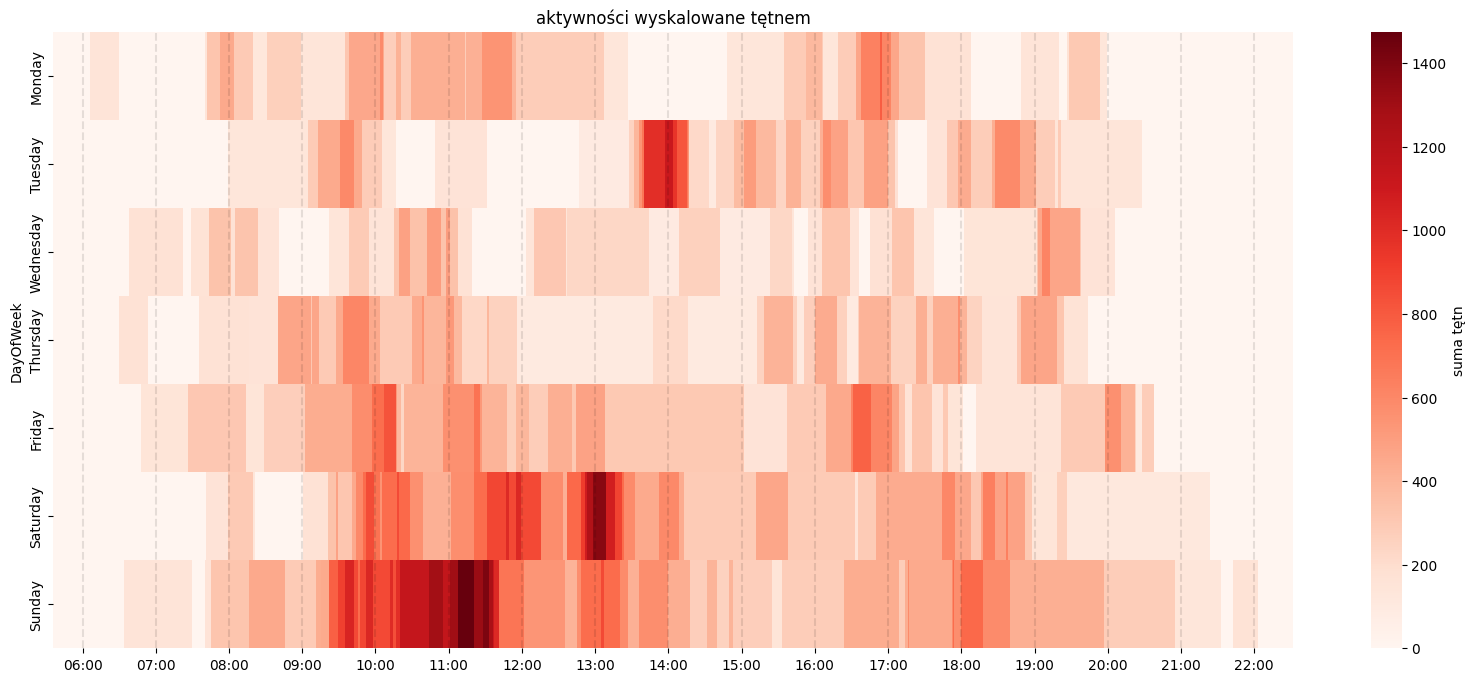

In [7]:
heart_rate_values=df_weeks["Average Heart Rate"].fillna(0).values[:,None]
weighted_activity_mask=activity_mask*heart_rate_values
weighted_activity_heatmap=(pd.DataFrame(weighted_activity_mask,index=df_weeks["Activity ID"],columns=minutes_named)
                    .reset_index()
                    .merge(df_weeks[["Activity ID","DayOfWeek"]],left_on="Activity ID",right_on="Activity ID")
                    .drop(columns="Activity ID")
                    .groupby("DayOfWeek").sum()
                    .rename(index=days_of_week)
                    .fillna(0))

weighted_activity_sum=weighted_activity_heatmap.sum()
active_minutes=weighted_activity_sum.to_numpy().nonzero()[0]
margin=30
if len(active_minutes)>0:
    first_idx=active_minutes[0]
    last_idx=active_minutes[-1]
    start_cut = max(0, first_idx - margin)
    end_cut = min(1440, last_idx + margin)
    weighted_heatmap_cropped=weighted_activity_heatmap.iloc[:,start_cut:end_cut]
plt.figure(figsize=(20, 8))
ax=sns.heatmap(weighted_heatmap_cropped,cmap="Reds",xticklabels=False,cbar="Suma średnich tętn",cbar_kws={'label': 'suma tętn'})
cols=weighted_heatmap_cropped.columns
ticks=[i for i, name in enumerate(cols) if name.endswith(":00")]
labels=[cols[i] for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_title("aktywności wyskalowane tętnem")
ax.vlines(ticks, *ax.get_ylim(), colors="black", linestyles="--", alpha=0.1)

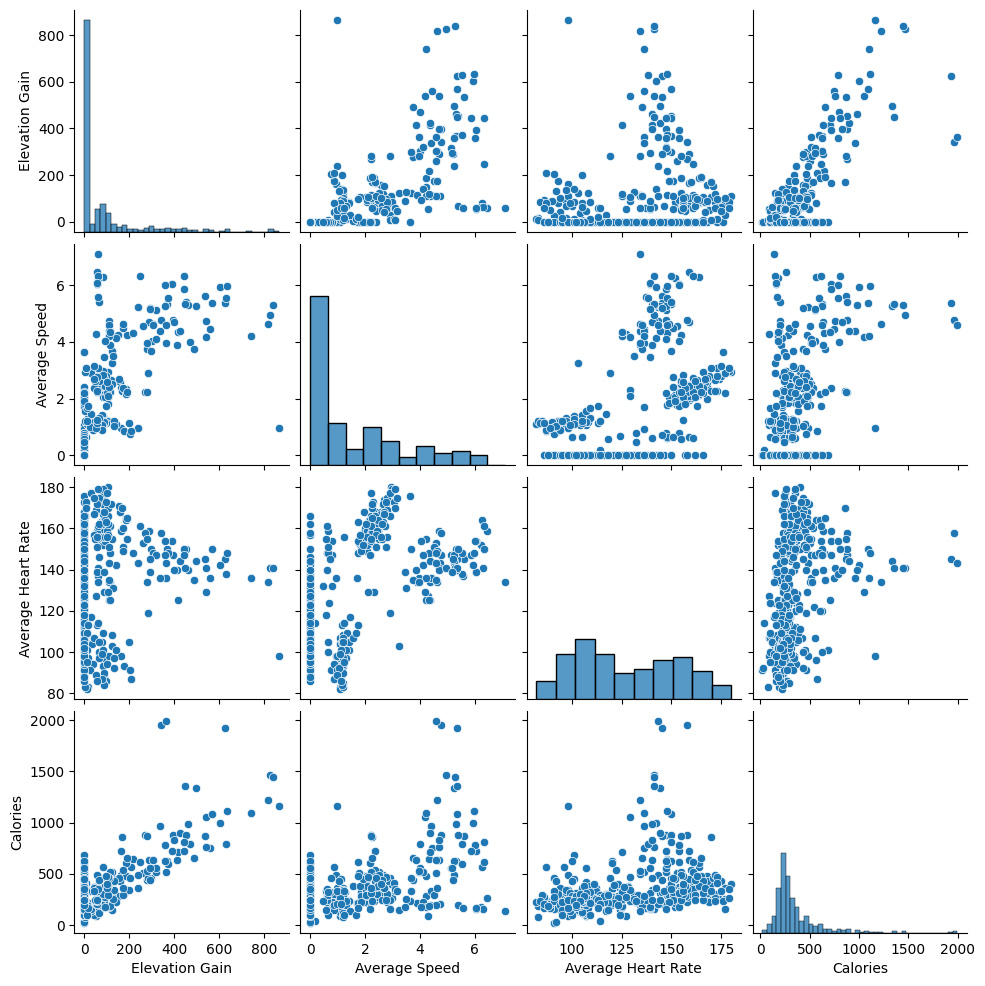

In [10]:
pp_df = df[['Distance', 'Elevation Gain', 'Average Speed', 'Average Heart Rate', 'Calories']]
sns.pairplot(pp_df)